# Covid-19-Peak-Predictor-using-LSTM
1. Data Source from OUR WORLD in Data GitHub repository.
2. Goal to predict COVID-19 peak using Time Series Analysis
3. Dataset available here: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy
from matplotlib import dates
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import Javascript
from datetime import datetime
from pandas.api.types import is_numeric_dtype
from google.colab import files
import os
import time
import getpass
import statistics
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from pylab import rcParams
import missingno as msno
!pip install geopandas #for map
import geopandas as gpd
from pandas import DataFrame
from pandas import to_datetime

import seaborn as sns
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 55)

#import sklearn packages
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller #Dickey-Fuller Test
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import Holt

#Import keras Lib
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Bidirectional
from keras.layers.advanced_activations import LeakyReLU

# Use bokeh to plot predictions
import bokeh.io
bokeh.io.reset_output()
bokeh.io.output_notebook()
from bokeh.plotting import figure, show, output_notebook
from bokeh.io import output_notebook
from bokeh.models import Legend
from bokeh.models import NumeralTickFormatter

import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.preprocessing import MinMaxScaler




/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 6.3 MB 35.3 MB/s 
     |████████████████████████████████| 15.4 MB 36.0 MB/s 


In [2]:
#loading the URL
covid_url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
#read the CSV file
cdata = pd.read_csv(covid_url, error_bad_lines=False)


In [3]:
#Number of columns
cdata.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
#Display all rows
pd.set_option('display.max_rows',None)

In [5]:
#Total rows
cdata.shape

(139837, 67)

In [6]:
#Checking for null values
cdata.isnull().sum()

iso_code                                           0
continent                                       8890
location                                           0
date                                               0
total_cases                                     7803
new_cases                                       7808
new_cases_smoothed                              8848
total_deaths                                   19176
new_deaths                                     18980
new_deaths_smoothed                             8848
total_cases_per_million                         8479
new_cases_per_million                           8484
new_cases_smoothed_per_million                  9519
total_deaths_per_million                       19839
new_deaths_per_million                         19643
new_deaths_smoothed_per_million                 9519
reproduction_rate                              29307
icu_patients                                  122725
icu_patients_per_million                      

In [7]:
#Dropping unrequired columns
cdata.drop(['excess_mortality_cumulative_per_million','excess_mortality_cumulative_absolute','excess_mortality_cumulative','excess_mortality','human_development_index','hospital_beds_per_thousand','handwashing_facilities','male_smokers','female_smokers','gdp_per_capita','diabetes_prevalence','cardiovasc_death_rate','extreme_poverty','gdp_per_capita','population_density','reproduction_rate','continent',],axis=1, inplace= True)

In [8]:
cdata.head()

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
1,AFG,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
2,AFG,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
3,AFG,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
4,AFG,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83


In [9]:
#Checking columns with 80% null values 
cdata.isnull().sum() >= (119656 * 0.80)

iso_code                                      False
location                                      False
date                                          False
total_cases                                   False
new_cases                                     False
new_cases_smoothed                            False
total_deaths                                  False
new_deaths                                    False
new_deaths_smoothed                           False
total_cases_per_million                       False
new_cases_per_million                         False
new_cases_smoothed_per_million                False
total_deaths_per_million                      False
new_deaths_per_million                        False
new_deaths_smoothed_per_million               False
icu_patients                                   True
icu_patients_per_million                       True
hosp_patients                                  True
hosp_patients_per_million                      True
weekly_icu_a

In [10]:
# dropping column with 80% null values
cdata.drop(['icu_patients','icu_patients_per_million','hosp_patients','hosp_patients_per_million','weekly_hosp_admissions','weekly_hosp_admissions_per_million','weekly_icu_admissions','weekly_icu_admissions_per_million'],axis=1,inplace= True)

In [11]:
cdata.head(1)

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83


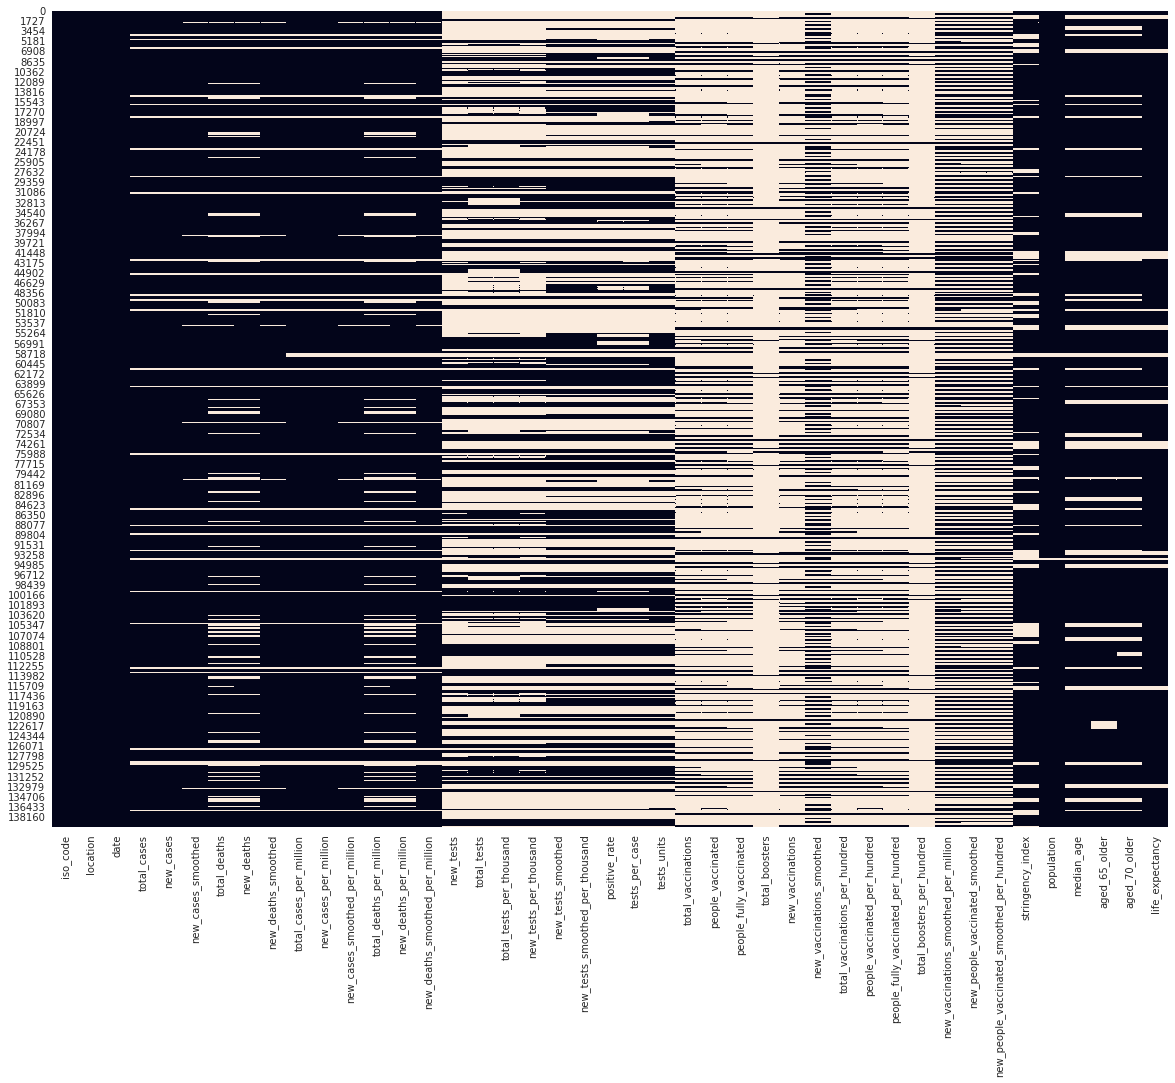

In [12]:
plt.subplots(figsize=(20,15))
sns.heatmap(cdata.isnull(), cbar=False)

In [13]:
cdata.head(2)

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
1,AFG,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83


In [14]:
#Fill NaN values with 0
cdata.fillna(0,inplace=True)


In [15]:
cdata.head(2)

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,0.0,0.0,0.0,0.0,0.126,0.126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
1,AFG,Afghanistan,2020-02-25,5.0,0.0,0.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83


In [16]:
cdata.isnull().sum()

iso_code                                      0
location                                      0
date                                          0
total_cases                                   0
new_cases                                     0
new_cases_smoothed                            0
total_deaths                                  0
new_deaths                                    0
new_deaths_smoothed                           0
total_cases_per_million                       0
new_cases_per_million                         0
new_cases_smoothed_per_million                0
total_deaths_per_million                      0
new_deaths_per_million                        0
new_deaths_smoothed_per_million               0
new_tests                                     0
total_tests                                   0
total_tests_per_thousand                      0
new_tests_per_thousand                        0
new_tests_smoothed                            0
new_tests_smoothed_per_thousand         

In [17]:
cdata.head(10)

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,0.000,0.0,0.0,0.0,0.126,0.126,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
1,AFG,Afghanistan,2020-02-25,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
2,AFG,Afghanistan,2020-02-26,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
3,AFG,Afghanistan,2020-02-27,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
4,AFG,Afghanistan,2020-02-28,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
5,AFG,Afghanistan,2020-02-29,5.0,0.0,0.714,0.0,0.0,0.0,0.126,0.000,0.018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
6,AFG,Afghanistan,2020-03-01,5.0,0.0,0.714,0.0,0.0,0.0,0.126,0.000,0.018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83
7,AFG,Afghanistan,2020-03-02,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83
8,AFG,Afghanistan,2020-03-03,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83
9,AFG,Afghanistan,2020-03-04,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83


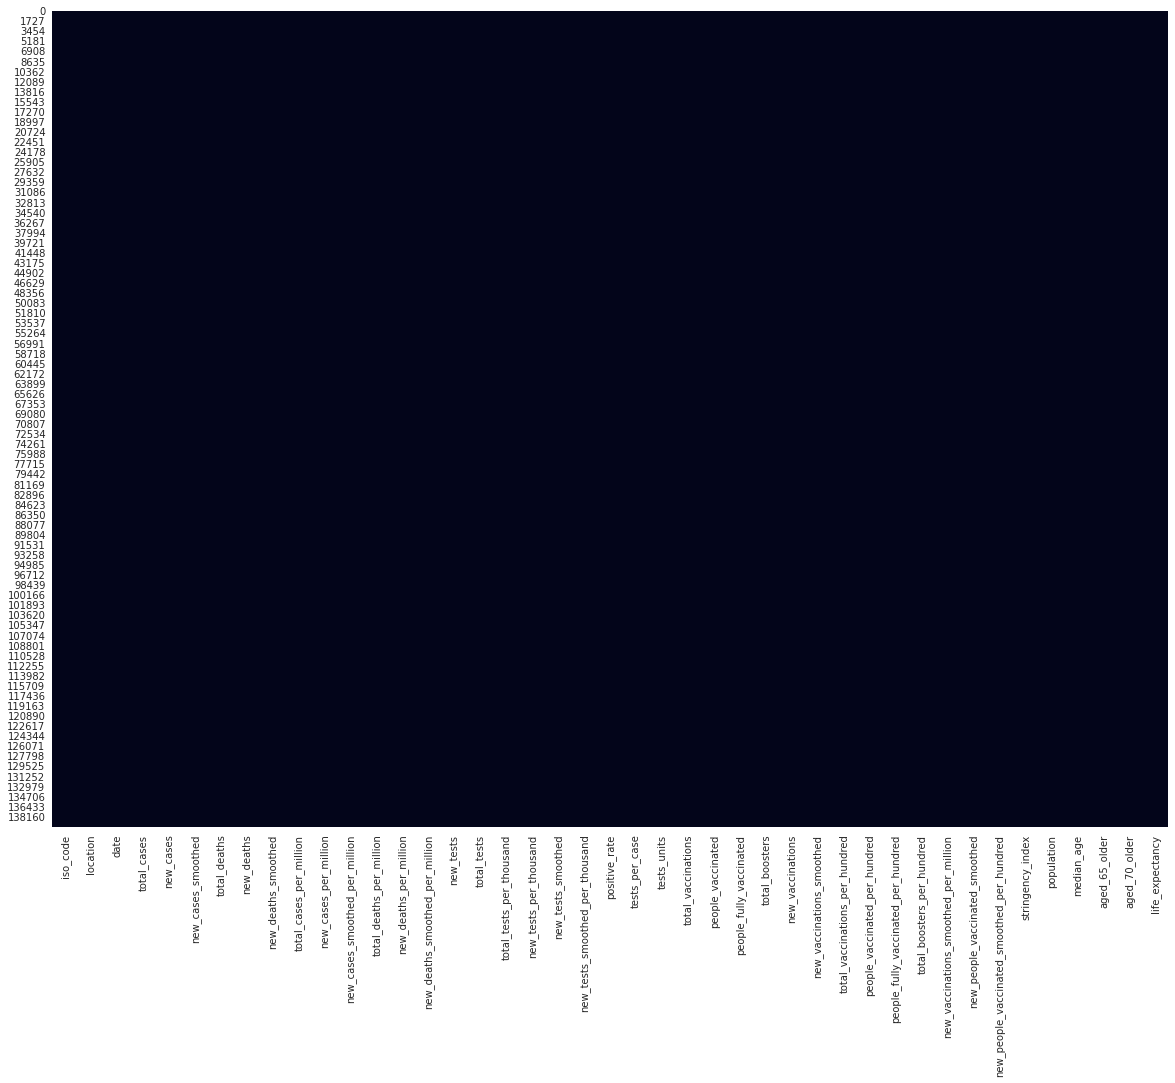

In [18]:
plt.subplots(figsize=(20,15))
sns.heatmap(cdata.isnull(), cbar=False)

In [19]:
cdata['location'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

In [20]:
clist = cdata.sort_values(by="new_cases_per_million",ascending=False)
clist['location'].head(5000).unique()

array(['Vatican', 'Andorra', 'Palestine', 'Dominica', 'Seychelles',
       'Liechtenstein', 'Grenada', 'Belgium', 'Maldives', 'Botswana',
       'Kazakhstan', 'Belize', 'Saint Kitts and Nevis', 'Slovakia',
       'Lesotho', 'Sweden', 'San Marino', 'Luxembourg',
       'Antigua and Barbuda', 'Saint Vincent and the Grenadines',
       'Hungary', 'Switzerland', 'Czechia', 'Israel', 'Kosovo',
       'Mongolia', 'Slovenia', 'Cyprus', 'Saint Lucia', 'Uruguay', 'Fiji',
       'Spain', 'Bahrain', 'Croatia', 'Suriname', 'Austria', 'France',
       'Kyrgyzstan', 'Estonia', 'Latvia', 'Ireland', 'Monaco', 'Portugal',
       'Georgia', 'Barbados', 'Lithuania', 'Serbia', 'Norway',
       'Montenegro', 'Netherlands', 'Denmark', 'Costa Rica', 'Bahamas',
       'Brunei', 'Namibia', 'Germany', 'Iceland', 'Equatorial Guinea',
       'Mauritius', 'Panama', 'Bosnia and Herzegovina', 'Bulgaria',
       'Oman', 'United Kingdom', 'Malta', 'Romania', 'Singapore',
       'Poland', 'Jordan', 'Eswatini', 'United 

In [21]:
clist = cdata.sort_values(by="new_cases_per_million",ascending=True)
clist2 = clist.sort_values(by="positive_rate",ascending=True)
clist2['location'].head(200).unique()

array(['Kazakhstan', 'Mali', 'Uzbekistan', 'United Kingdom', 'Low income',
       'Burundi', 'Africa', 'Gambia', 'Poland', 'Papua New Guinea',
       'Georgia', 'Algeria', 'Uruguay', 'Indonesia', 'Tajikistan',
       'Egypt', 'Mauritania', 'Angola', 'Czechia', 'Sudan', 'Malawi',
       'Netherlands', 'Upper middle income', 'Lesotho', 'Djibouti',
       'Syria', 'Sierra Leone', 'Asia', 'Kenya', 'Guinea', 'Jordan',
       'Cameroon', 'Oceania', 'Bosnia and Herzegovina', 'Oman', 'Haiti',
       'Iran', 'European Union', 'Gabon', 'France', 'Ukraine', 'Brazil',
       'Hong Kong', 'Austria', 'Afghanistan', 'Dominican Republic',
       'Somalia', 'Eritrea', 'Benin', 'Liberia', 'Germany', 'South Sudan',
       'Ethiopia', 'Central African Republic', 'Colombia', 'Switzerland'],
      dtype=object)

# LSTM Forecast

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



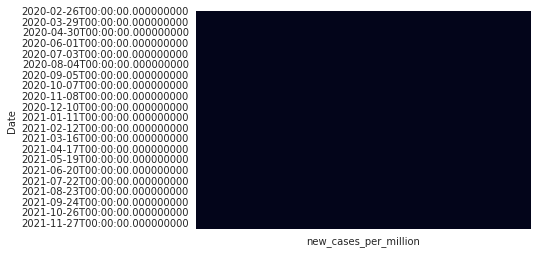

In [22]:
# Checking for stationary values
country = 'Norway'
ndata = cdata
ndata.head(2)
ndata['Date'] = pd.to_datetime(ndata['date'])
df2 = ndata.copy()
df2.set_index('Date', inplace= True)
tdata = df2[df2['location'].isin([country])]
tdata.head(2)
tdata.dropna(inplace= True)
ndata2 = tdata[['new_cases_per_million']]
sns.heatmap(ndata2.isnull(), cbar=False)

In [23]:
ndata2.head(2)

,new_cases_per_million
Date,
2020-02-26,0.183
2020-02-27,0.000


In [24]:
ndata2.tail(2)

,new_cases_per_million
Date,
2021-12-12,662.687
2021-12-13,0.000


In [25]:
values = ndata2.values
values = values.reshape((len(values),1))

scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(values)
#print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

#scaler = StandardScaler()
#scaler = scaler.fit(values)
#print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))

normalized = scaler.transform(values)
#print(normalized)

X = scaler.inverse_transform(normalized)
#print(X)

In [26]:
#X = ndata2.values
#X = X.reshape((-1,1))

In [27]:
split_percent = 0.7
split = int(split_percent*len(X))

X_train = X[:split]
X_test = X[split:]

date_train = ndata2.index[:split]
date_test = ndata2.index[split:]

In [28]:
look_back = 18
train_gen = TimeseriesGenerator(X_train, X_train, length= look_back, batch_size= 64)
test_gen = TimeseriesGenerator(X_test, X_test, length= look_back, batch_size= 64)
print(train_gen)
print(test_gen)

In [29]:
# set layers for LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(85, activation= 'relu', input_shape= (look_back, 1)))
#lstm_model.add(Dropout(0.05))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer= 'Adam', loss= 'mse')
num_epochs = 500
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 85)                29580     
                                                                 
 dense (Dense)               (None, 1)                 86        
                                                                 
Total params: 29,666
Trainable params: 29,666
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = lstm_model.fit(train_gen,epochs=num_epochs,verbose=2)
#loss_train = history.history['loss']
#add = sum(loss_train)
#avg = add/len(loss_train)
#if  avg > 1000:
#  num_epochs = 1000
#  history = lstm_model.fit(train_gen,epochs=num_epochs,verbose=2)
#  print('Average greater than 1000')   
#print(history.history['loss'])
#print(history.history['accuracy'])

Epoch 1/500
7/7 - 2s - loss: 3873.3687 - 2s/epoch - 279ms/step
Epoch 2/500
7/7 - 0s - loss: 748.4631 - 126ms/epoch - 18ms/step
Epoch 3/500
7/7 - 0s - loss: 608.3582 - 126ms/epoch - 18ms/step
Epoch 4/500
7/7 - 0s - loss: 611.6206 - 129ms/epoch - 18ms/step
Epoch 5/500
7/7 - 0s - loss: 598.0828 - 129ms/epoch - 18ms/step
Epoch 6/500
7/7 - 0s - loss: 559.8002 - 152ms/epoch - 22ms/step
Epoch 7/500
7/7 - 0s - loss: 553.2739 - 129ms/epoch - 18ms/step
Epoch 8/500
7/7 - 0s - loss: 468.7278 - 137ms/epoch - 20ms/step
Epoch 9/500
7/7 - 0s - loss: 441.0599 - 136ms/epoch - 19ms/step
Epoch 10/500
7/7 - 0s - loss: 437.0971 - 140ms/epoch - 20ms/step
Epoch 11/500
7/7 - 0s - loss: 517.6418 - 135ms/epoch - 19ms/step
Epoch 12/500
7/7 - 0s - loss: 459.8095 - 137ms/epoch - 20ms/step
Epoch 13/500
7/7 - 0s - loss: 425.1835 - 132ms/epoch - 19ms/step
Epoch 14/500
7/7 - 0s - loss: 431.2608 - 145ms/epoch - 21ms/step
Epoch 15/500
7/7 - 0s - loss: 418.9800 - 130ms/epoch - 19ms/step
Epoch 16/500
7/7 - 0s - loss: 403.6

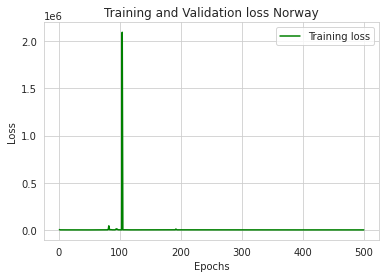

In [31]:
loss_train = history.history['loss']
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training and Validation loss '+ country)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [32]:
prediction = lstm_model.predict(test_gen)
print(prediction.shape[0])

180


In [33]:
# plot data
# reshape to plot
X_train = X_train.reshape((-1))
X_test = X_test.reshape((-1))
prediction = prediction.reshape((-1))

# plot using plotly
trace1 = go.Scatter(
    x = date_train,
    y = X_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = X_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = 'LSTM '+country+' Prediction',
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : 'New_cases_per_million'}
)

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

fig.update_layout(
    autosize=False,
    width=1600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)

fig.show()


In [34]:
# calculate RMSE
X_test = X_test[:prediction.shape[0]]

lstm_rmse = sqrt(mean_squared_error(X_test, prediction, squared= False))
print('RMSE for '+ country +' : {:,.2f} '.format(lstm_rmse))

RMSE for Norway : 10.26 


In [35]:
lstm_mape = round(np.mean(np.abs((X_test - prediction)/X_test))*100, 3)  
print('MAPE for ' +country+ ': ', lstm_mape)

MAPE for Norway:  77.326


In [36]:
# functions to forecast model
X = X.reshape((-1))


def predict(num_prediction, model):
    prediction_list = X[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

# create future dates for x-axis    
def predict_dates(num_prediction):
    last_date = ndata2.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates
 
# num_prediction = number of days into future
num_prediction = 250
forecast = predict(num_prediction, lstm_model)
forecast_dates = predict_dates(num_prediction)

In [37]:
# plot data
trace1 = go.Scatter(
    x = ndata2.index,
    y = X,
    mode = 'lines',
    name = 'Original Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Forecasted Data'
)
layout = go.Layout(
    title = 'LSTM ' +country+ ' Forecast',
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : 'new cases'}
)

fig = go.Figure(data=[trace1, trace2], layout=layout,)
fig.update_layout(
    autosize=False,
    width=1600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [38]:
# Checking for stationary values
def forecast(nation):
  ndata = cdata
  ndata.head(2)
  ndata['Date'] = pd.to_datetime(ndata['date'])
  df2 = ndata.copy()
  df2.set_index('Date', inplace= True)
  tdata = df2[df2['location'].isin([nation])]
  tdata.head(2)
  tdata.dropna(inplace= True)
  ndata2 = tdata[['new_cases_per_million']]
  sns.heatmap(ndata2.isnull(), cbar=False)
  
  values = ndata2.values
  values = values.reshape((len(values),1))
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler = scaler.fit(values)
  normalized = scaler.transform(values)
  X = scaler.inverse_transform(normalized)
  
  split_percent = 0.7
  split = int(split_percent*len(X))
  X_train = X[:split]
  X_test = X[split:]
  date_train = ndata2.index[:split]
  date_test = ndata2.index[split:]
  
  look_back = 18
  train_gen = TimeseriesGenerator(X_train, X_train, length= look_back, batch_size= 64)
  test_gen = TimeseriesGenerator(X_test, X_test, length= look_back, batch_size= 64)
  lstm_model = Sequential()
  lstm_model.add(LSTM(85, activation= 'relu', input_shape= (look_back, 1)))
  lstm_model.add(Dense(1))
  lstm_model.compile(optimizer= 'Adam', loss= 'mse')
  num_epochs = 500
  history = lstm_model.fit(train_gen,epochs=num_epochs,verbose=0)
  
  loss_train = history.history['loss']
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  plt.rcParams["figure.figsize"] = (50,30)

  prediction = lstm_model.predict(test_gen)
  print(prediction.shape[0])
  
  X_train = X_train.reshape((-1))
  X_test = X_test.reshape((-1))
  prediction = prediction.reshape((-1))
  
  trace1 = go.Scatter(
    x = date_train,
    y = X_train,
    mode = 'lines',
    name = 'Data'
  )
  trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
  )
  trace3 = go.Scatter(
    x = date_test,
    y = X_test,
    mode='lines',
    name = 'Ground Truth'
  )
  layout = go.Layout(
    title = 'LSTM '+ nation +' Prediction',
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : 'New_cases_per_million'}
  )
  fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
  fig.update_layout(
    autosize=False,
    width=1600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
    )
  fig.show()
  
  X = X.reshape((-1))
  def predict(num_prediction, model):
    prediction_list = X[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

  def predict_dates(num_prediction):
    last_date = ndata2.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates
 
  num_prediction = 250
  forecast = predict(num_prediction, lstm_model)
  forecast_dates = predict_dates(num_prediction)
  
  trace1 = go.Scatter(
    x = ndata2.index,
    y = X,
    mode = 'lines',
    name = 'Original Data'
  )
  trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Forecasted Data'
  )
  layout = go.Layout(
    title = 'LSTM '+ nation +' Forecast',
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : 'new cases'}
  )
  fig = go.Figure(data=[trace1, trace2], layout=layout,)
  fig.update_layout(
    autosize=False,
    width=1600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
  )

  fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



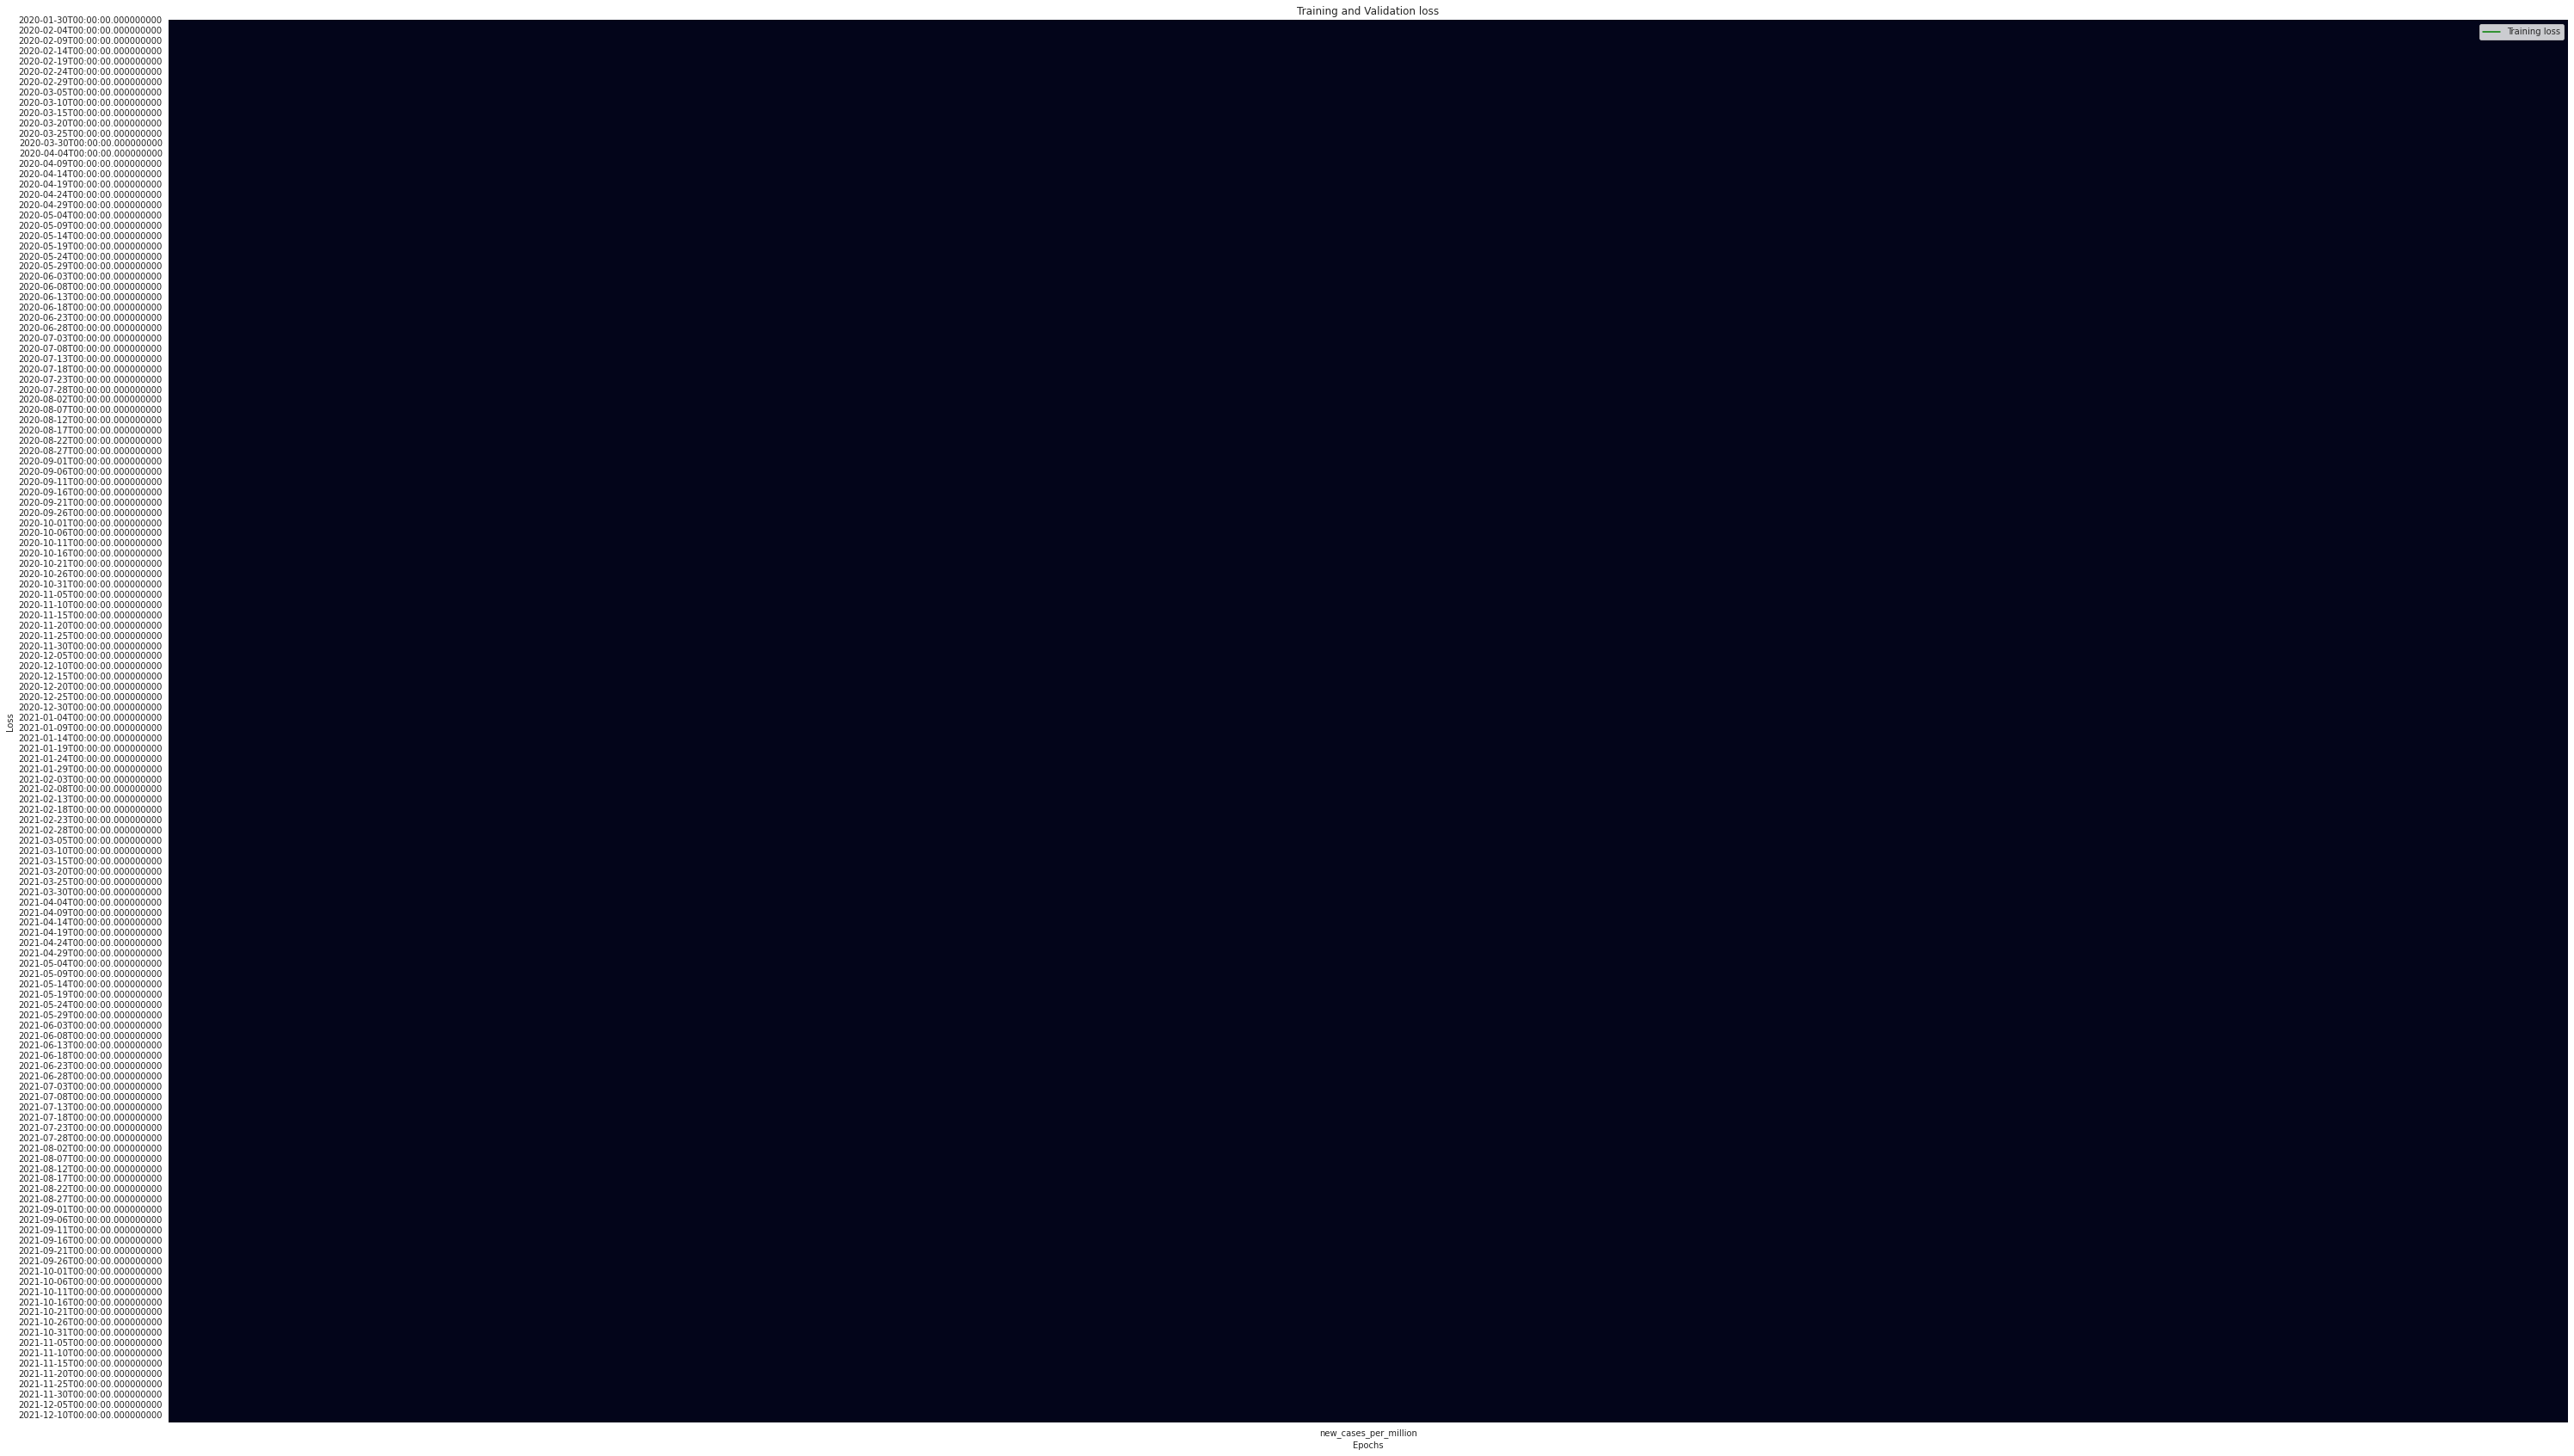

188


In [42]:
forecast('India')